In [1]:
import Pkg
Pkg.activate("../../Tasks2D")

using Revise, Plots
import LineWorlds
const L = LineWorlds

  Activating project at `~/Developer/research/summer2023/tasks2d/Tasks2D`


LineWorlds

In [2]:
col = palette(:default);

In [3]:
_segs, _boxes, _bb, _center, _xs, _hds, _ps, _dxs, _dhds, _us, _T = L.load_env();

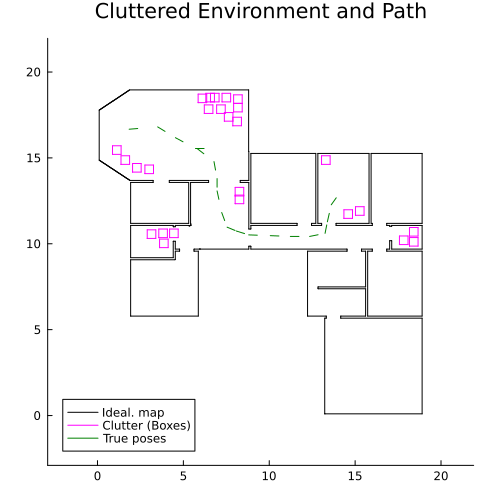

In [4]:
mypl = plot(size=(500,500), aspect_ratio=:equal, title="Cluttered Environment and Path", grid=false,
xlim=(_bb[1][1]-3, _bb[2][1]+3),
ylim=(_bb[1][2]-3, _bb[2][2]+3),
legend=:bottomleft,
)
plot!(_segs, c=:black, linewidth=1, label="Ideal. map")
plot!(_boxes, c=:magenta, label="Clutter (Boxes)")
plot!(_ps[[1]], c=:green, linewidth=1, label="True poses")
plot!(_ps[2:end], c=:green, linewidth=1, label=nothing)

In [5]:
using Gen

In [6]:
gm             = HomogeneousMixture(L.diagnormal, [1, 1])
outlier_dist   = L.diagnormal
sensor_mix     = HeterogeneousMixture([gm, outlier_dist])
sensor_product = L.ProductDistribution(sensor_mix)

# Todo: Ideally I could wrap this distribution into a type that allows
#       for changes to the signature and replacing the logpdf.

# Creating the arguments is tedious, here's a helper that
# makes it less painful
function sensor_product_args(ỹ, sig, outlier, outlier_vol, zmax) 
    n,m, = size(ỹ)
    ỹ_perm = permutedims(ỹ, (1,3,2))
    args = (
        fill([1-outlier, outlier], n), 
        fill(1/m, n, m), 
        ỹ_perm, 
        fill(sig, n, 2,m), 
        fill(0.0, n,2), 
        fill(zmax, n,2)
    )
    return args
end

sensor_product_args (generic function with 1 method)

In [7]:

ỹ = rand(361, 21, 2)
sig         = 0.1
outlier     = 0.1
outlier_vol = 100.
zmax        = 100.
args = sensor_product_args(ỹ, sig, outlier, outlier_vol, zmax) 
x = sensor_product(args...)

using BenchmarkTools
@btime sensor_product($args...) samples=3 evals=3;
@btime logpdf($sensor_product, $x, $args...) samples=3 evals=3;

  1.114 ms (16903 allocations: 1.02 MiB)


  8.243 ms (161014 allocations: 5.64 MiB)


In [19]:
@gen function sensor_model_v1(p, segs, w, sig, outlier, outlier_vol, zmax)
    # p    = Vector(p)
#     ps   = reshape(p, 1, 3)
    # segs = L.stack(Vector.(segs))
    _as = L.create_angles(2π, 100)
    zs = reshape(L.cast([p], segs; num_a=100), (1, :))
    ỹ  = L.get_2d_mixture_components(zs, _as, w)[1,:,:,:]
    ỹ   = ỹ

    args = sensor_product_args(ỹ, sig, outlier, outlier_vol, zmax) 
    x ~ sensor_product(args...)
    
    return x
end;

In [21]:
t = 7

p  = _ps[t]
the_map = _segs

w            = 5
s_noise      = 0.2
outlier      = 0.1
outliver_vol = 100.0
zmax         = 100.0

args  = (p, the_map, w, s_noise, outlier, outliver_vol, zmax)
tr = simulate(sensor_model_v1, args);
get_choices(tr);

In [89]:
x  = sensor_model_v1(args...)
ch = choicemap(:x => x)

@btime sensor_model_v1($args...)              samples=5 evals=5;
@btime simulate($sensor_model_v1, $args)      samples=5 evals=5;
@btime generate($sensor_model_v1, $args, $ch) samples=5 evals=5;

  1.038 ms (5987 allocations: 3.14 MiB)
  2.345 ms (31600 allocations: 4.05 MiB)
  1.987 ms (26925 allocations: 3.81 MiB)


In [33]:
# This works on CPU
@gen function sensor_model_CPU(p, segs, w, s_noise, outlier, outlier_vol, zmax=100.0)
    
    # segs = L.stack(Vector.(segs))
    _as = L.create_angles(2π, 300)
    zs = reshape(L.cast([p], segs; num_a=300), (1, :))
    ỹ  = L.get_2d_mixture_components(zs, _as, w)[1,:,:,:]
    
    x ~ L.sensordist_2dp3(ỹ, s_noise, outlier, outlier_vol)    
    return x
end;


In [34]:
sensor_model = sensor_model_CPU

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any, Any, Any, Any, Any, Any, Any], true, Union{Nothing, Some{Any}}[nothing, nothing, nothing, nothing, nothing, nothing, Some(100.0)], var"##sensor_model_CPU#668", Bool[0, 0, 0, 0, 0, 0, 0], false)

In [35]:
t = 7

p  = _ps[t]
m  = _segs

w            = 5
s_noise      = 0.2
outlier      = 0.1
outlier_vol = 100.0
zmax = 100.0

args  = (p, m, w, s_noise, outlier, outlier_vol, zmax)
x  = sensor_model(args...)
ch = choicemap(:x => x)

@btime sensor_model($args...)              samples=5 evals=5;
@btime simulate($sensor_model, $args)      samples=5 evals=5;
@btime generate($sensor_model, $args, $ch) samples=5 evals=5;

  294.942 μs (3248 allocations: 554.67 KiB)


  401.042 μs (3341 allocations: 812.83 KiB)


  389.117 μs (2506 allocations: 740.22 KiB)


  280.125 μs (3243 allocations: 554.36 KiB)


  388.639 μs (3372 allocations: 814.35 KiB)


  374.867 μs (2533 allocations: 741.47 KiB)


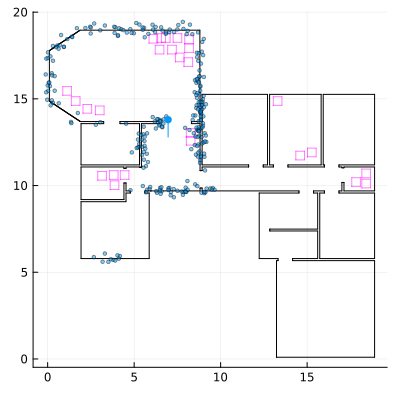

In [37]:
t = 7

p  = _ps[t]

sensor_args = (
    w            = 5,
    s_noise      = 0.2,
    outlier      = 0.1,
    outliver_vol = 100.0,
)

args  = (p, _segs, sensor_args...)
tr = simulate(sensor_model, args)
x = tr[]

ch = choicemap(:x => x)

@btime sensor_model(args...)            samples=3 evals=3;
@btime simulate(sensor_model, args)     samples=3 evals=3;
@btime generate(sensor_model, args, ch) samples=5 evals=5;

# -------------------------------
plot(size=(400,400), aspect_ratio=:equal, legend=nothing)
plot!(_segs, c=:black)
plot!(_boxes, c=:magenta, alpha=0.5)
scatter!(x.*_ps[t], c=col[1], alpha=0.5, markersize=2)
scatter!(_ps[t], c=col[1])